In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #change after Filter implementation
from generator import MCTS

c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

Search is started.
0- time: 0.18, count_rollouts: 1, reward: -0.2771201899120502, node: PEPTIDE1{W.Q.M.G.H.S}$$$$
1- time: 0.31, count_rollouts: 2, reward: -0.9451442283798714, node: PEPTIDE1{Y.P.S.K.P.D.N.P.G.E.D.A.P.A.E.D.L.A.R.Y.Y.S.A.L.R.H.Y.I.N.L.I.T.R.Q.R.Y.[am]}$$$$
2- time: 0.48, count_rollouts: 3, reward: -0.694190508925101, node: PEPTIDE1{[ac].F.Q.S.K.R.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
3- time: 0.88, count_rollouts: 5, reward: -0.16480318103546554, node: PEPTIDE1{Y.[dA].F.D.V.V.G.[am]}$$$$
4- time: 1.11, count_rollouts: 7, reward: -0.13773888738353732, node: PEPTIDE1{F.P.A.S}$$$$
5- time: 1.13, count_rollouts: 8, reward: -0.8631379588134164, node: PEPTIDE1{A.D.Y.I.H.P.F.T.N.S.Y.R.R.Q.R.Y.I.N.L.G.Q.R.Y.[am]}$$$$
6- time: 1.25, count_rollouts: 9, reward: -0.6622299542859064, node: PEPTIDE1{T.P.R.E.R.R.R.W.K.R.E}$$$$
7- time: 1.31, count_rollouts: 10, reward: 0.00401997834520442, node: PEPTIDE1{K.L.P.P}$$$$
8- time: 1.35, count_rollouts: 11, reward: 0.0756153885281098, no

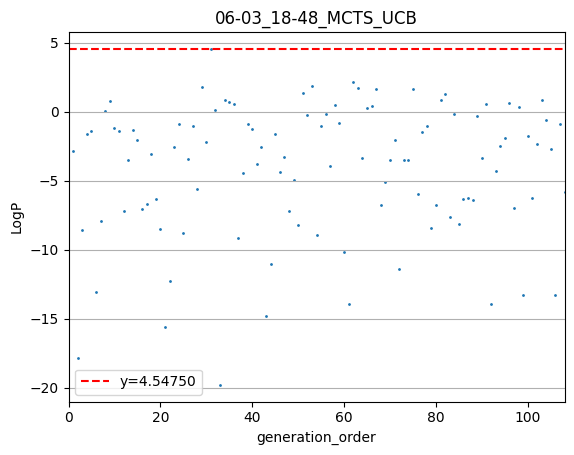

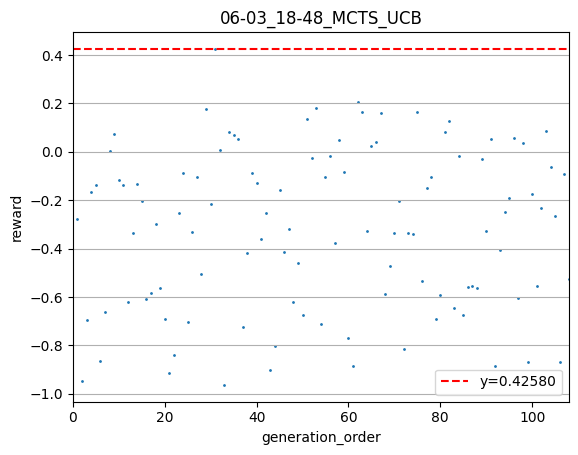

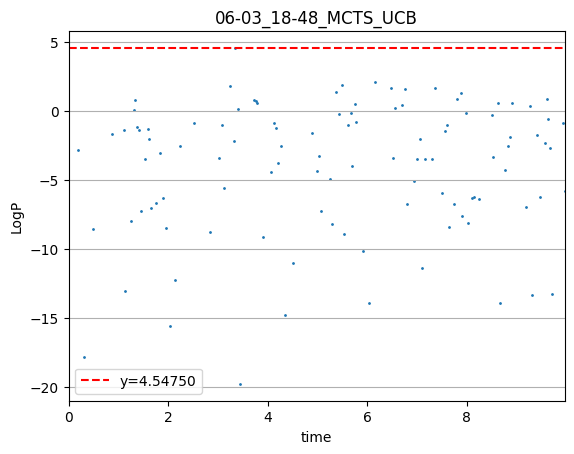

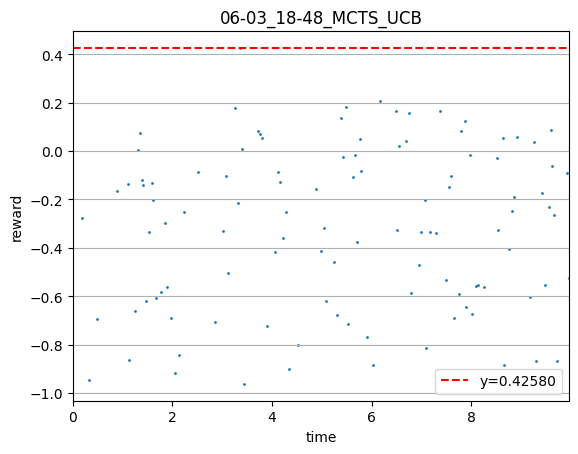

Search is completed.


In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)